In [108]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import copy
from astropy.io import fits
import astropy.units as u
from astropy.modeling.models import BlackBody

We are following the following equation to get to a BB spectrum:

$$
D(\nu) = e^{i\nu\psi} H(\nu)^{-1} \left(\frac{1}{Z(\omega)B(\omega)} Y(\nu) - C(\nu)\right).
$$

Get interferogram

In [57]:
gmt = b'89326172801540'

fdq_sdf = h5py.File("/mn/stornext/d16/cmbco/ola/firas/initial_data/fdq_sdf_new.h5")["fdq_sdf_ll"]
fdq_eng = h5py.File("/mn/stornext/d16/cmbco/ola/firas/initial_data/fdq_eng_new.h5")

sci_id = list(fdq_sdf["ct_head/gmt"]).index(gmt)

print(sci_id)

4400


In [58]:
eng_time = fdq_sdf["dq_data/eng_time"][sci_id]
eng_id = list(fdq_eng["ct_head/time"]).index(eng_time)

print(eng_id)

4265


In [59]:
xcal_pos = fdq_sdf["dq_data/xcal_pos"][sci_id]
print(xcal_pos)

2


In [60]:
mtm_length = fdq_sdf["sci_head/mtm_length"][sci_id]
mtm_speed = fdq_sdf["sci_head/mtm_speed"][sci_id]

In [61]:
fake_it = fdq_sdf["dq_data/fake"][sci_id]

In [62]:
upmode = fdq_sdf["sci_head/sc_head1a"][sci_id]

In [63]:
adds_per_group = fdq_sdf["sci_head/sc_head9"][sci_id]

In [64]:
ifg = fdq_sdf["ifg_data/ifg"][sci_id]

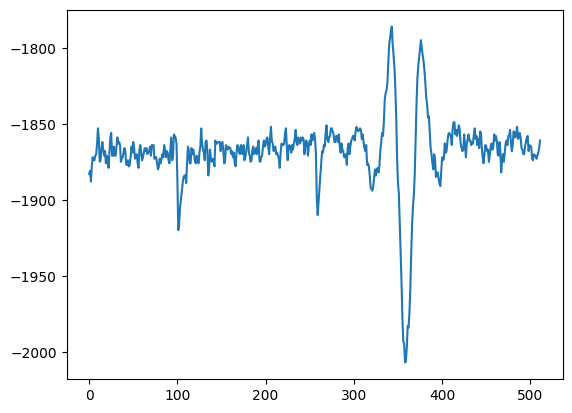

In [65]:
plt.plot(ifg)
plt.show()

Subtract the dither

In [66]:
ifg = ifg - np.median(ifg)

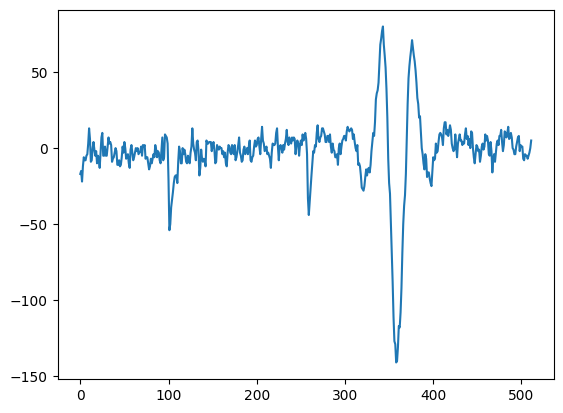

In [67]:
plt.plot(ifg)
plt.show()

Get rid of the biggest glitches

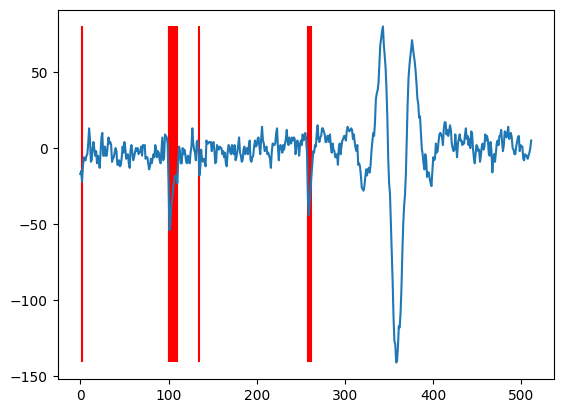

In [68]:
ifg_maxs = copy.deepcopy(ifg)

ordered_maxs = []
for i in range(len(ifg)):
    ordered_maxs.append(np.argmax(np.abs(ifg_maxs)))
    ifg_maxs[ordered_maxs[-1]] = 0

plt.vlines(ordered_maxs[26], np.min(ifg), np.max(ifg), color="red")
plt.vlines(ordered_maxs[30], np.min(ifg), np.max(ifg), color="red")
plt.vlines(ordered_maxs[34], np.min(ifg), np.max(ifg), color="red")
plt.vlines(ordered_maxs[37], np.min(ifg), np.max(ifg), color="red")
plt.vlines(ordered_maxs[42:45], np.min(ifg), np.max(ifg), color="red")
plt.vlines(ordered_maxs[49], np.min(ifg), np.max(ifg), color="red")
plt.vlines(ordered_maxs[53], np.min(ifg), np.max(ifg), color="red")
plt.vlines(ordered_maxs[58:60], np.min(ifg), np.max(ifg), color="red")
plt.vlines(ordered_maxs[62:64], np.min(ifg), np.max(ifg), color="red")
plt.vlines(ordered_maxs[68], np.min(ifg), np.max(ifg), color="red")
plt.vlines(ordered_maxs[71:74], np.min(ifg), np.max(ifg), color="red")

plt.plot(ifg)
plt.show()

6.0 -6.0


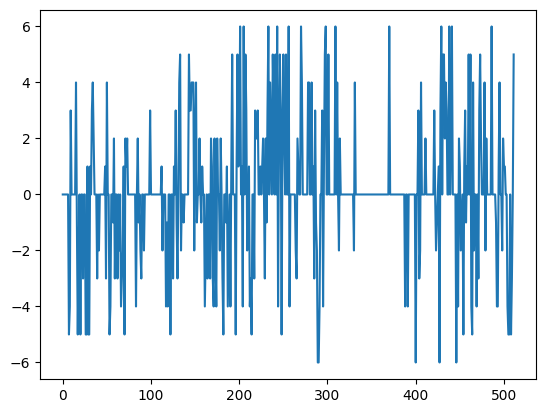

In [69]:
averaged_ifg = copy.deepcopy(ifg)

for i in range(len(ifg)//2):
    averaged_ifg[ordered_maxs[i]] = 0

print(np.max(averaged_ifg), np.min(averaged_ifg))

plt.plot(averaged_ifg)

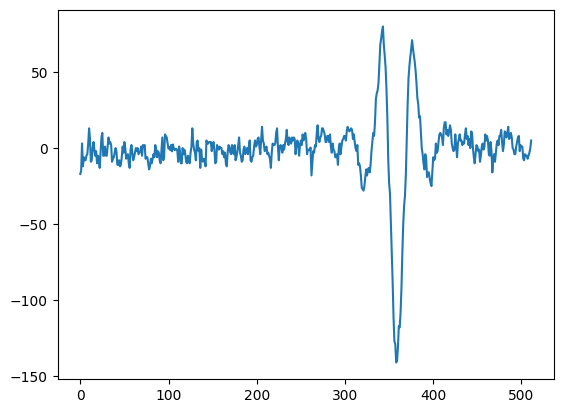

In [70]:
std = np.std(averaged_ifg)

glitch_idx = [26, 30, 34, 37, 42, 43, 44, 49, 53, 58, 59, 62, 63, 68, 71, 72, 73]
deglitched_ifg = copy.deepcopy(ifg)

for i in glitch_idx:
    deglitched_ifg[ordered_maxs[i]] = np.random.normal(0, std)

plt.plot(deglitched_ifg)
plt.show()

Apodize

In [71]:
from utils.fut import apod_recnuml

channel = 3 # (LL)
sm = 2 * mtm_length + mtm_speed
fake_it

arecno = apod_recnuml(channel, sm, fake_it, upmode, adds_per_group, 0)

In [72]:
from utils.frd import apodl

apodl_all = apodl()
apod = apodl_all[arecno, :]

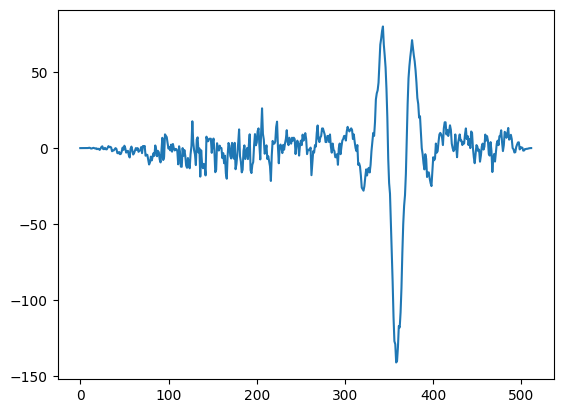

In [73]:
ai = apod * deglitched_ifg

plt.plot(ai)
plt.show()

Padding

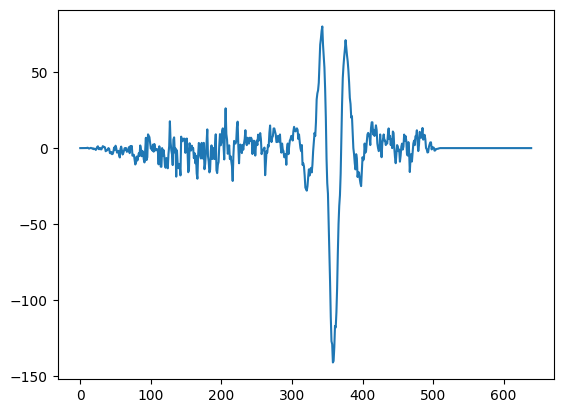

In [74]:
padding = np.zeros(640 - 512)
padded = np.concatenate((ai, padding))

plt.plot(padded)
plt.show()

Fourier transform

(321,)


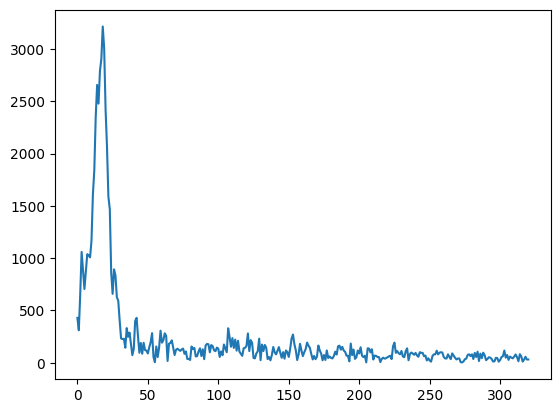

In [75]:
y = np.fft.rfft(padded)
print(y.real.shape)

plt.plot(np.abs(y)) # plotting the amplitude spectrum
plt.show()

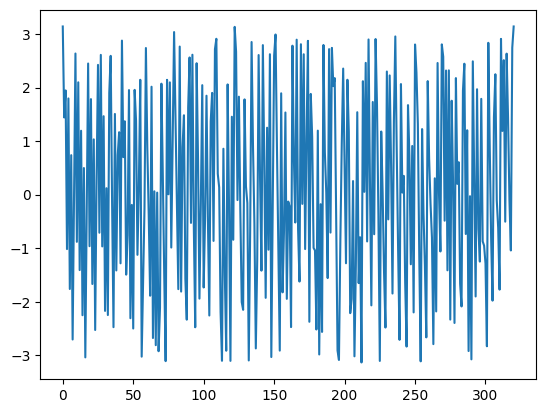

In [76]:
plt.plot(np.angle(y)) # plotting the phase spectrum
plt.show()

Electronics transfer function to get the volts

In [77]:
from utils.frd import elex_transfcnl
from utils.fut import get_recnum

etfl_all = elex_transfcnl(samprate=681.43, nfreq=len(y.real))
erecno = get_recnum(fake_it, mtm_speed, channel, upmode, adds_per_group)
etf = etfl_all[erecno, :]

[        inf  3.36775327  6.5563064  10.38487276  8.50739048  6.57684271
  7.86648672  9.15359367  8.78464307  8.36392294  9.3878306  12.57340237
 13.99752768 17.37768182 19.15000369 17.42684733 19.16380163 19.53821165
 21.18117324 19.43630013 15.3791572  12.90776981  9.76690688  8.9041172
  5.14455546  3.89171591  5.21571887  4.83463276  3.59243081  3.36055751
  2.26891491  1.29839095  1.25051103  1.26473231  0.78446418  1.80258727
  1.34207917  1.55463782  0.94906762  0.38674359  0.69561406  2.12007641
  2.27232214  1.33878906  0.50082818  0.99146666  0.45020406  0.99791183
  0.63280757  0.60562549  0.46160102  0.77123546  1.02177551  1.47103061
  0.28884647  0.02539543  0.80689777  0.28399782  0.76318109  1.59392362
  0.99694405  1.11709558  1.46577791  1.33847189  0.08707438  0.94889836
  0.98741649  1.11755768  0.73803441  0.3864745   0.64894633  0.70191628
  0.65084043  0.59668917  0.67043283  0.71477688  0.45059915  0.57320749
  0.19061195  0.19878624  0.14050563  0.82981711  0.

/tmp/ipykernel_3270113/1107810168.py:1: RuntimeWarning: divide by zero encountered in divide
  yz = y / etf * u.V
/tmp/ipykernel_3270113/1107810168.py:1: RuntimeWarning: invalid value encountered in divide
  yz = y / etf * u.V


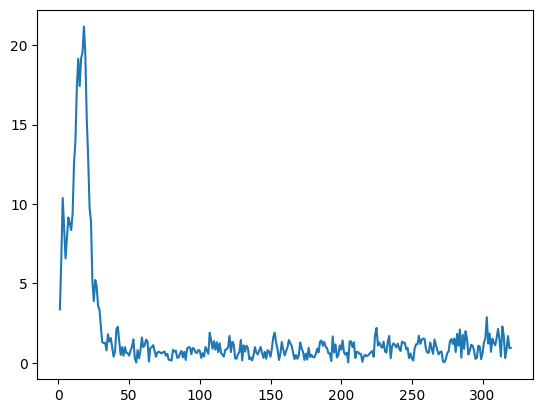

In [78]:
yz = y / etf * u.V

plt.plot(np.abs(yz)) # plotting the amplitude spectrum
plt.show()

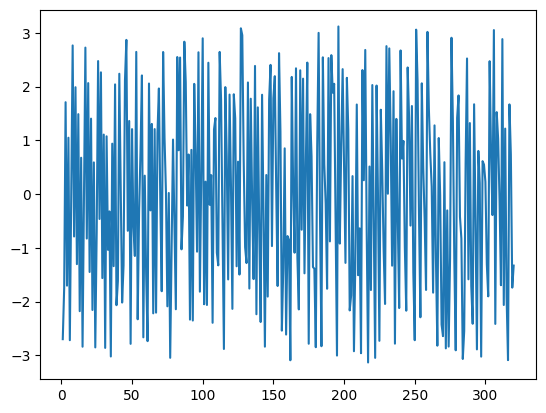

In [92]:
plt.plot(np.angle(yz)) # plotting the phase spectrum
plt.show()

Bolometer model

In [80]:
fits_data = fits.open('FIRAS_CALIBRATION_MODEL_LLSS.FITS')

In [103]:
tau = fits_data[1].data['TIME_CON'][0] * u.s
S0 = fits_data[1].data['DC_RESPO'][0] * u.V / u.W

f_nyquist = 145.212 / u.cm
nu = np.arange(320)*(f_nyquist/320) + 2 / u.cm
nu = nu[:43]
dnu = nu[1] - nu[0]

dGHz = dnu.to(u.GHz, equivalencies=u.spectral())
f = np.arange(321) * dGHz + 30 * u.GHz

print(max(f))

4383.346241109598 GHz


In [88]:
omega = f.value * 6.283185307179586
omega = omega * u.rad / u.s

In [91]:
bolometer = S0 / (1 + 1j * omega.value * tau.value)

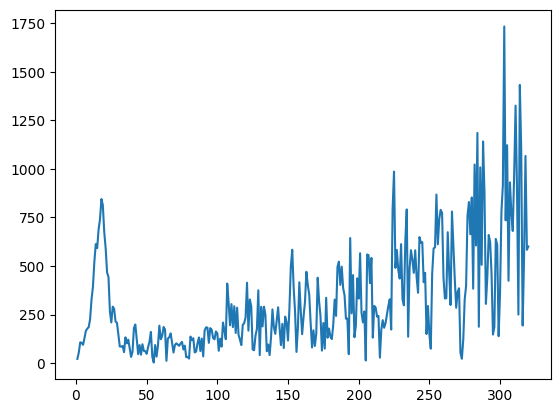

In [93]:
yzb = yz / bolometer

plt.plot(np.abs(yzb)) # plotting the amplitude spectrum
plt.show()

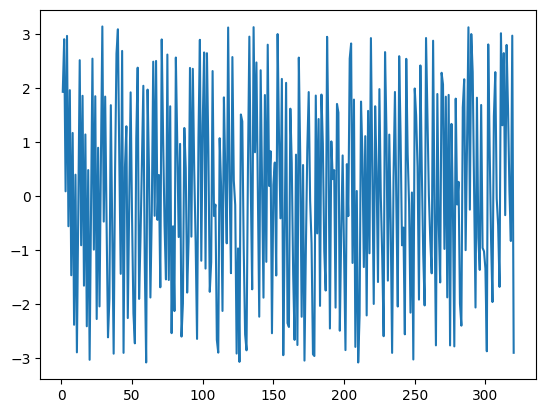

In [94]:
plt.plot(np.angle(yzb)) # plotting the phase spectrum
plt.show()

Cut off high frequencies

In [97]:
cutoff = yzb[:43]

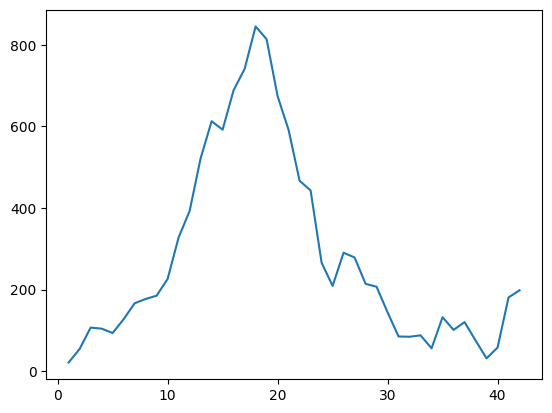

In [99]:
plt.plot(np.abs(cutoff)) # plotting the amplitude spectrum
plt.show()

Optical transfer function

43

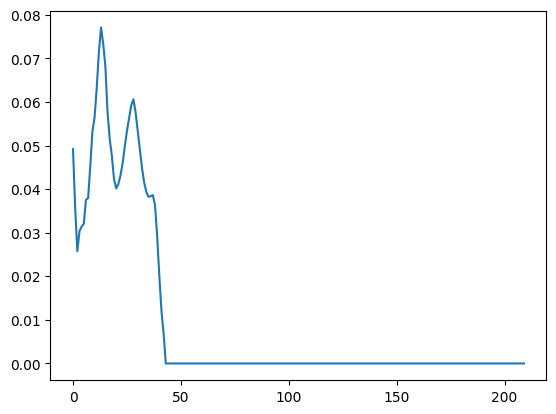

In [110]:
otf = fits_data[1].data["RTRANSFE"][0] + 1j * fits_data[1].data["ITRANSFE"][0]

plt.plot(np.abs(otf)) # plotting the amplitude spectrum
len(otf[np.abs(otf) > 0])

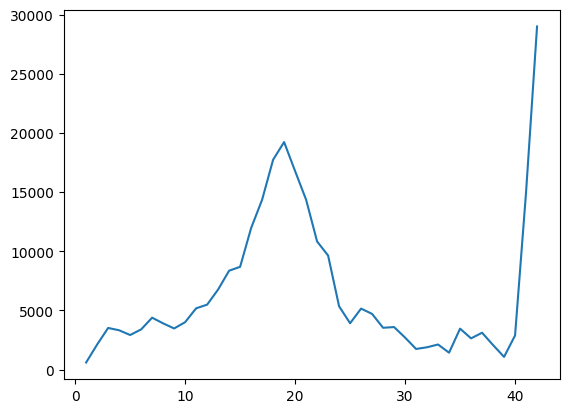

In [102]:
yzbh = cutoff / otf[:43]

plt.plot(np.abs(yzbh)) # plotting the amplitude spectrum
plt.show()

In [105]:
phase = 1e-5 * u.cm

d = np.exp(1j*nu*phase) * yzbh

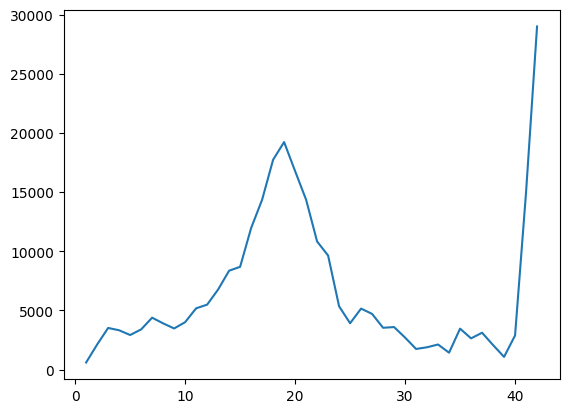

In [106]:
plt.plot(np.abs(d)) # plotting the amplitude spectrum
plt.show()

In [127]:
ical_emiss = fits_data[1].data["RICAL"][0] + 1j * fits_data[1].data["IICAL"][0]

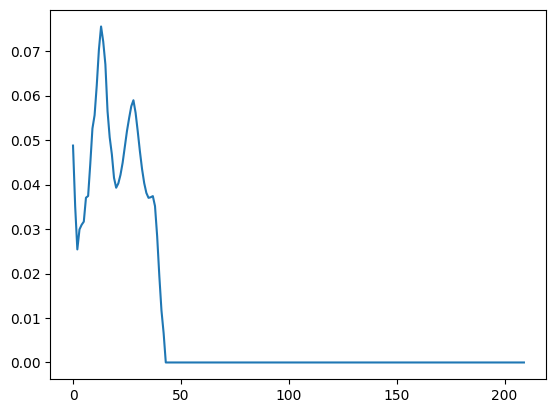

In [128]:
plt.plot(np.abs(ical_emiss)) # plotting the amplitude spectrum
plt.show()

In [132]:
t_ical = t_ical = (0.1 * fdq_eng["en_analog/grt/a_hi_ical"][eng_id] + 0.9 * fdq_eng["en_analog/grt/b_hi_ical"][eng_id]) * u.K

bb_ical = BlackBody(temperature=t_ical)(f[:43]) * ical_emiss[:43]

todo: match dimensions (get d into astrophysical units)

In [133]:
sky = d - bb_ical / otf[:43]

UnitConversionError: Can only apply 'subtract' function to quantities with compatible dimensions

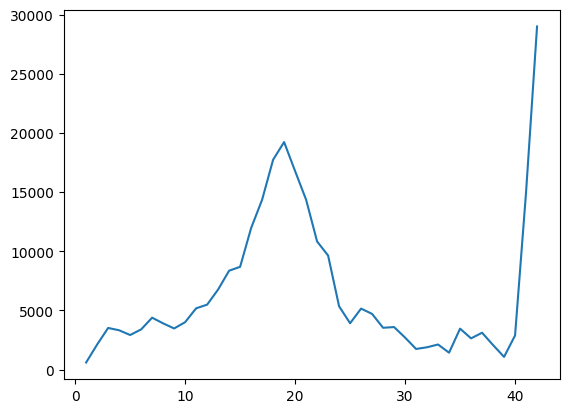

In [119]:
plt.plot(np.abs(sky)) # plotting the amplitude spectrum
plt.show()

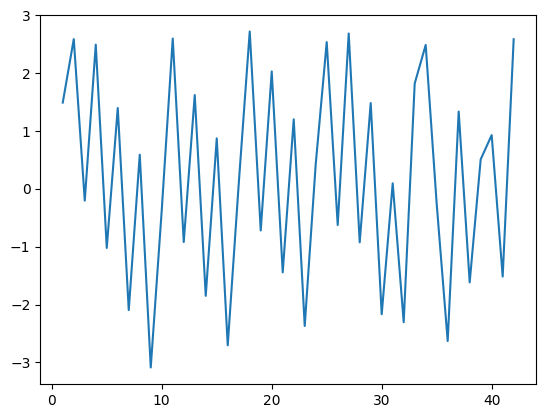

In [120]:
plt.plot(np.angle(sky)) # plotting the phase spectrum
plt.show()

In [125]:
from astropy.modeling import fitting

fit_t = fitting.TRFLSQFitter()
bb = BlackBody(2.725 * u.K)(f[:43])

fitted_bb = fit_t(bb.value, f[:43].value, sky)

plt.plot(f[:43], sky)
plt.plot(f[:43], fitted_bb(f[:43]))
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute '_has_units'